# Analytics Vidya Hackathon Computer Vision June-2020

Link: https://datahack.analyticsvidhya.com/contest/janatahack-computer-vision-hackathon/

Team:
- Praveen Raghuvanshi
- Suman Kanukollu

### References
- [How to Train an Image Classifier in PyTorch and use it to Perform Basic Inference on Single Images](
https://towardsdatascience.com/how-to-train-an-image-classifier-in-pytorch-and-use-it-to-perform-basic-inference-on-single-images-99465a1e9bf5)



# Setup

In [1]:
import torch
from IPython.display import Image, clear_output 

print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

PyTorch 1.5.0+cu101 _CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


In [54]:
# Load data from Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 4.31 ms


In [9]:
import sys,os

homepath = '/content/drive/My Drive/suman_fastAI/janataHackathon'
os.chdir(homepath)

!ls

 AV_jantahackathon_CV_V3.ipynb	      emergencyVsNonEm.ipynb   train.csv
'AV_jantahackathon_CV_V4 (1).ipynb'   images		       train.zip
 AV_jantahackathon_CV_V4.ipynb	      jantahackathon.pth
 data				      test.csv
time: 7.75 s


# Install Extensions

In [2]:
!pip install ipython-autotime
%load_ext autotime

# Constants, import libraries

In [10]:
import torch,torchvision
from torchvision.datasets import ImageFolder
from PIL import Image

import pandas as pd
import numpy as np


time: 1.79 ms


# Albumentations

In [11]:
import albumentations as alb
from albumentations.pytorch import ToTensor
class album_compose_train:
    def __init__(self):
        #meandata, stddata=album_calculate_dataset_mean_std()
        mean_color=(0.4804, 0.4482, 0.3976)
        #channel_mean=(meandata[0]+meandata[1]+meandata[2])/3.0
        #print('channel mean',channel_mean)
        self.albtransform = alb.Compose([
                #alb.PadIfNeeded(min_height=80, min_width=80, border_mode=cv2.BORDER_CONSTANT, value=np.array(mean_color)*255),
                #alb.RandomCrop(64,64,always_apply=True),
                #alb.Rotate((-30.0,30.0)),
                #alb.ToGray(),
                #alb.RandomBrightnessContrast(),
                alb.HorizontalFlip(p=0.5),
                #alb.RandomResizedCrop(64, 64, scale=(0.75, 1.0), ratio=(0.9, 1.1), p=0.75),
                #alb.Cutout(num_holes=4,max_h_size=16, max_w_size=16,fill_value=0.4421*255),
                #alb.CoarseDropout(max_holes=8, max_height=16, max_width=16, min_holes=1, min_height=8, min_width=8,fill_value=0, p=1.0),
                #alb.Normalize((0.4804, 0.4482, 0.3976), (0.277, 0.269, 0.282)),
                ToTensor(),
        ])
 
    def __call__(self,img):
        img=np.array(img)
        img=self.albtransform(image=img)
        return img['image']

class album_compose_test:
    def __init__(self):
        #meandata, stddata=album_calculate_dataset_mean_std()
        self.albtransform = alb.Compose([
        
        #print('meandata[0]:',meandata[0]),
        alb.Normalize((0.4804, 0.4482, 0.3976), (0.277, 0.269, 0.282)),
        ToTensor(),
        ])
 
    def __call__(self,img):
        img=np.array(img)
        img=self.albtransform(image=img)
        return img['image']



time: 16.3 ms


# Dataset read

In [12]:
class emgNemgDs(torch.utils.data.Dataset,album_compose_train,album_compose_test):
    def __init__(self,train=True):
        self.path,self.trainFn, self.testFn = os.path.join(homepath,'images'),'train.csv','test.csv'
        self.train = train
        if self.train:
            self.ds = pd.read_csv('train.csv').to_numpy()
        else:
            self.ds  = pd.read_csv('test.csv').to_numpy()
        self.transform = album_compose_train()

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        img_name = os.path.join(self.path, self.ds[idx][0])
        image = Image.open(img_name)
        image = self.transform(image)
        if self.train:
            labels = self.ds[idx][1]
            return image,labels
        else:
            #labels = self.ds[idx]
            return image

        

time: 20.3 ms


In [13]:
trainDs = emgNemgDs(train=True)
testDs  = emgNemgDs(train=False)
print('Train DS length is : {}\nTest DS length is : {}'.format(len(trainDs),len(testDs)))


Train DS length is : 1646
Test DS length is : 706
time: 18.4 ms


In [14]:
from torch.utils.data import random_split
train_ds,val_ds = random_split(trainDs,[1235,411])

print('Dataset is splitted into 75%+25%:\n\ttrain_ds len is : {}\n\tval_ds len is : {}'.format(len(train_ds),len(val_ds)))

Dataset is splitted into 75%+25%:
	train_ds len is : 1235
	val_ds len is : 411
time: 3.98 ms


# Dataloader

In [15]:
from torch.utils.data import DataLoader,random_split

SEED = 1
# For reproducibility
torch.manual_seed(SEED)

torch.cuda.manual_seed(SEED)

train_loader = DataLoader(train_ds, batch_size = 16, shuffle =True, pin_memory=True,num_workers =0)
val_loader  = DataLoader(val_ds, batch_size = 8, shuffle =True, pin_memory=True,num_workers =0)

test_loader = DataLoader(testDs,batch_size = 8, shuffle =True, pin_memory=True,num_workers =0)

time: 5.37 ms


# Display images

In [63]:
import torchvision
from matplotlib import pyplot as plt

def show(imgs,lbls=None, figsize=(100,100), *args, **kwargs):
    grid_tensor = torchvision.utils.make_grid(imgs[:8], *args, **kwargs)
    grid_image = grid_tensor.permute(1,2,0)
    plt.figtext(100,100,'suman')
    plt.figure(figsize=figsize)
    plt.imshow(grid_image)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    if lbls is not None:
        print(' '.join('%22s' % [lbls[j]] for j in range(8)))
    plt.close()


time: 11.7 ms


<Figure size 432x288 with 0 Axes>

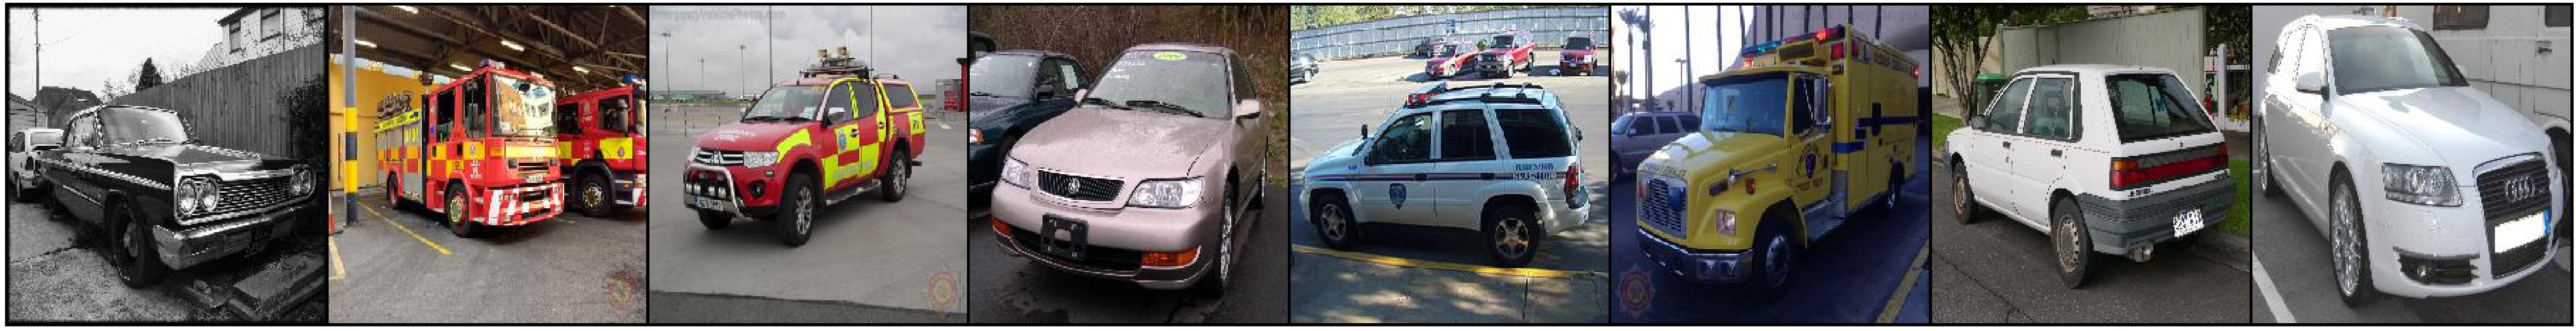

           [tensor(0)]            [tensor(1)]            [tensor(1)]            [tensor(0)]            [tensor(1)]            [tensor(1)]            [tensor(0)]            [tensor(0)]
time: 1.29 s


In [64]:
dataiter = iter(train_loader)
img,lbl = dataiter.next()

show(img,lbl)

<Figure size 432x288 with 0 Axes>

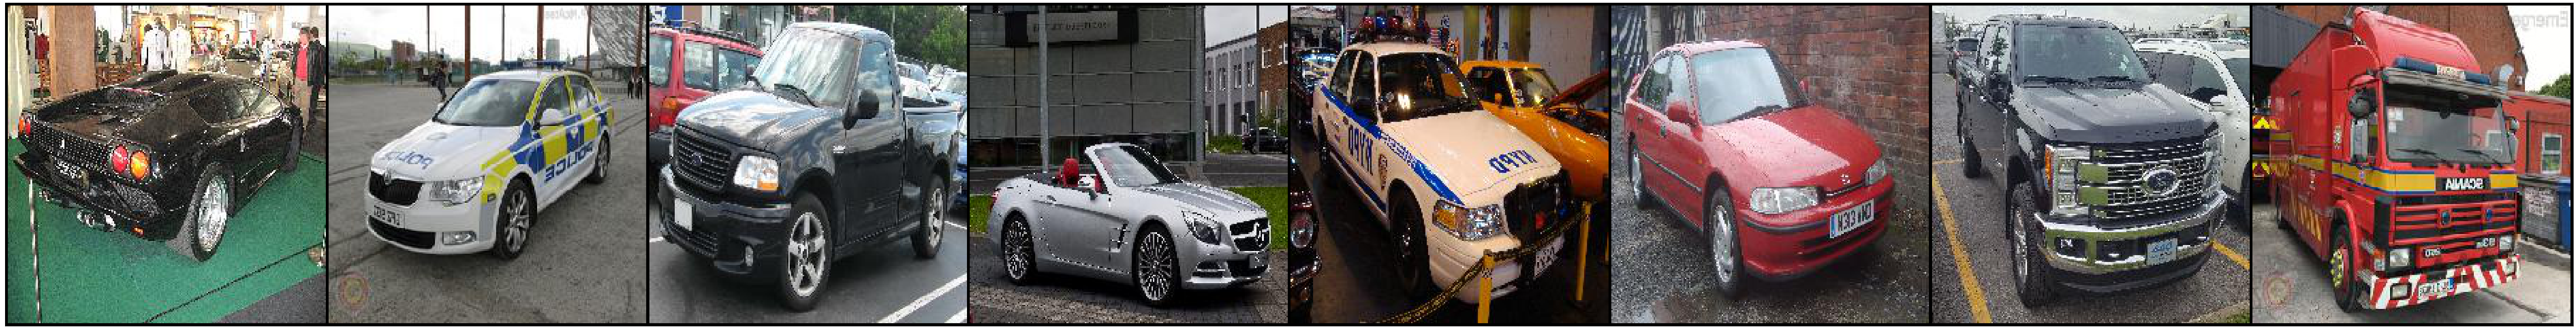

time: 3.3 s


In [65]:
dataiter = iter(test_loader)
img = dataiter.next()

show(img)

In [66]:
'''# Constants
TEST_CSV = '/content/drive/My Drive/jantahackathon/data/test_vc2kHdQ.csv'

TRAIN_CSV = '/content/drive/My Drive/jantahackathon/data/train.csv'
TOTAL_IMAGES_PATH = '/content/drive/My Drive/jantahackathon/data/full'
TOTAL_IMAGES_EMERGENCY_PATH = '/content/drive/My Drive/jantahackathon/data/full/emergency'
TOTAL_IMAGES_NOT_EMERGENCY_PATH = '/content/drive/My Drive/jantahackathon/data/full/notemergency'
TRAIN_ZIP = '/content/drive/My Drive/jantahackathon/data/train_SOaYf6m.zip'
ALL_IMAGES_PATH = '/content/drive/My Drive/jantahackathon/data/images'

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

from skimage.io import imread
from tqdm import tqdm

%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler

print(len(os.listdir(TOTAL_IMAGES_EMERGENCY_PATH)))
print(len(os.listdir(TOTAL_IMAGES_NOT_EMERGENCY_PATH)))
'''

"# Constants\nTEST_CSV = '/content/drive/My Drive/jantahackathon/data/test_vc2kHdQ.csv'\n\nTRAIN_CSV = '/content/drive/My Drive/jantahackathon/data/train.csv'\nTOTAL_IMAGES_PATH = '/content/drive/My Drive/jantahackathon/data/full'\nTOTAL_IMAGES_EMERGENCY_PATH = '/content/drive/My Drive/jantahackathon/data/full/emergency'\nTOTAL_IMAGES_NOT_EMERGENCY_PATH = '/content/drive/My Drive/jantahackathon/data/full/notemergency'\nTRAIN_ZIP = '/content/drive/My Drive/jantahackathon/data/train_SOaYf6m.zip'\nALL_IMAGES_PATH = '/content/drive/My Drive/jantahackathon/data/images'\n\nimport os\nimport pandas as pd\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport torch\n\nfrom skimage.io import imread\nfrom tqdm import tqdm\n\n%matplotlib inline\n\n# for creating validation set\nfrom sklearn.model_selection import train_test_split\n\n# PyTorch libraries and modules\nimport torch\nfrom torch.autograd import Variable\nfrom torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, Max

time: 6.31 ms


# Model

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torchvision.models.resnet50(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Freeze and modify final layer

In [68]:
for param in model.parameters():
    param.requires_grad = False
    

model.fc = torch.nn.Sequential(torch.nn.Linear(2048, 512),
                            torch.nn.ReLU(),
                            torch.nn.Dropout(0.2),
                            torch.nn.Linear(512, 2),
                            torch.nn.LogSoftmax(dim=1))

time: 16.2 ms


## Loss and Optimizer

In [69]:
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

time: 47 ms


# Training

In [ ]:
from tqdm import tqdm

epochs = 1
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []
for epoch in tqdm(range(epochs)):
    for inputs, labels in train_loader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(val_loader):.3f}.. "
                  f"Test accuracy: {accuracy/len(val_loader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, 'jantahackathon.pth')

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/1.. Train loss: 1.191.. Test loss: 1.058.. Test accuracy: 0.720
Epoch 1/1.. Train loss: 0.499.. Test loss: 0.883.. Test accuracy: 0.741


In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

# Load the saved model wts

In [27]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('jantahackathon.pth')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

time: 227 ms


In [18]:
from torchvision import transforms
test_transforms = transforms.Compose([transforms.ToTensor(),
                                      #transforms.Normalize([0.485, 0.456, 0.406],
                                      #                     [0.229, 0.224, 0.225])
                                     ])

time: 1.32 ms


In [28]:
from torch.autograd import Variable

def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    #input = image
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

def predict_image_bkp(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

time: 10.7 ms


In [29]:
def get_random_images(num):
    #data = datasets.ImageFolder(data_dir, transform=test_transforms)
    #classes = data.classes
    indices = list(range(len(val_ds)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    #loader = torch.utils.data.DataLoader(data, 
    #               sampler=sampler, batch_size=num)
    dataiter = iter(val_loader)
    images, labels = dataiter.next()
    return images, labels


def get_random_images_bkp(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

time: 11.3 ms


# Validation 

Misclassified Image :
	Actual Label : 1 and predicted : 0
Misclassified Image :
	Actual Label : 0 and predicted : 1


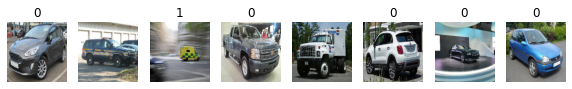

time: 743 ms


In [44]:
from matplotlib import pyplot as plt

to_pil = torchvision.transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    #print(index)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    if res:
        sub.set_title(index)
    else:
        print('Misclassified Image :\n\tActual Label : {} and predicted : {}'.format(int(labels[ii]),index))
    plt.axis('off')
    plt.imshow(image)
plt.show()

In [ ]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 8, kernel_size=3, stride=1, padding=1), # 224 -> 222
            BatchNorm2d(8),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),                 # 222 -> 111

            # Defining another 2D convolution layer
            Conv2d(8, 16, kernel_size=3, stride=1, padding=1), # 111 -> 109
            BatchNorm2d(16),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),                  # 109 -> 54

            # Defining another 2D convolution layer
            Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # 54 -> 52
            BatchNorm2d(32),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),                  # 52 -> 27

            # Defining another 2D convolution layer
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1), # 27 -> 25
            BatchNorm2d(128),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),                  # 25 -> 12

            # Defining another 2D convolution layer
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1), # 12 -> 10
            BatchNorm2d(32),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),                  # 10 -> 5
        )

        self.linear_layers = Sequential(
            Linear(4 * 5 * 5, 10)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x